#                                            Information Retrieval System: Image Similarity 

Integrantes: Kevin Valle, Madelyn Fernandez

In [1]:
import os
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
import pickle

Modelo ResNet50

In [2]:
img_size =224

model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

94773248/94765736 [==============================] - 0s 0us/step


Create the keras image data generator object and extract the features for the images using Resnet50 predict_generator method.

In [3]:
batch_size = 64
root_dir = '/kaggle/input/caltech101/101_ObjectCategories'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

feature_list = model.predict_generator(datagen, num_epochs,verbose = 1)

Found 9144 images belonging to 102 classes.
143/143 [==============================] - 85s 597ms/step


In [4]:
# Diccionario para almacenar las características extraídas
features_data = {}

for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    
    # Asegurarse de que sea un directorio (clase) antes de procesar
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            
            # Verifica si es un archivo antes de intentar cargarlo como imagen
            if os.path.isfile(img_path):
                img = image.load_img(img_path, target_size=(224, 224))
                img_data = image.img_to_array(img)
                img_data = np.expand_dims(img_data, axis=0)
                img_data = preprocess_input(img_data)

                # Extraer características
                features = model.predict(img_data)
                features_data[img_path] = features.flatten()

In [5]:
# Guardar las características extraídas en un archivo .pkl
with open('caltech101_features_new.pkl', 'wb') as f:
    pickle.dump(features_data, f)

In [6]:
print("Num images   = ", len(datagen.classes))
print("Shape of feature_list = ", feature_list.shape)

Num images   =  9144
Shape of feature_list =  (9144, 2048)


Verificación de las gráficas del dataset

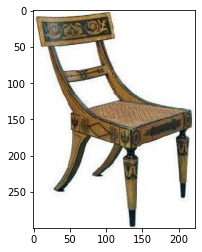

In [8]:
plt.imshow(plt.imread('/kaggle/input/caltech101/101_ObjectCategories/chair/image_0001.jpg'))
plt.show()

We have 9144 images in our dataset. Each image is converted into a 2048 feature vector.

In [9]:
# Get full path for all the images in our dataset

filenames = [root_dir + '/' + s for s in datagen.filenames]

In [10]:
# Guardar las características extraídas en un archivo .pkl
with open('caltech101_features_new1.pkl', 'wb') as f:
    pickle.dump(features_data, f)

Obtencion de los KNeighbors 

In [11]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean')

In [13]:
img_path = '/kaggle/input/example-images/descarga.jpeg'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)


In [14]:
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

(1, 5)


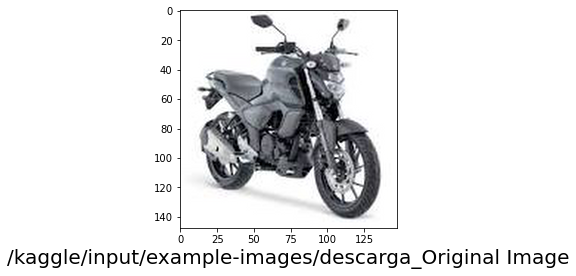

********* Predictions ***********


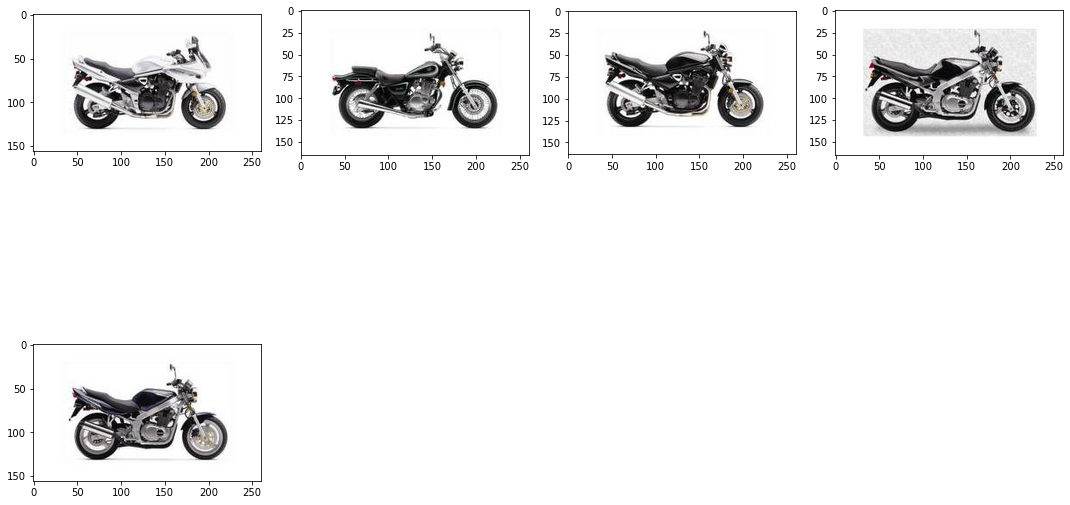

In [15]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

# Evaluación

In [16]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(#rotation_range=90,
                                                                brightness_range=(0.5,1), 
                                                                #shear_range=0.2, 
                                                                #zoom_range=0.2,
                                                                channel_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255,
                                                                validation_split=0.3)

In [17]:
img_generator_flow_train = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset="validation")

Found 6444 images belonging to 102 classes.
Found 2700 images belonging to 102 classes.


In [18]:
imgs, labels = next(iter(img_generator_flow_train))

In [36]:
base_model.trainable = False

In [37]:
new_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(102, activation="softmax")
])

In [39]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [40]:
new_model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, steps_per_epoch=20, epochs=50) #20,50

Epoch 1/50
20/20 [==============================] - 21s 1s/step - loss: 8.9575 - categorical_accuracy: 0.2578 - val_loss: 5.3874 - val_categorical_accuracy: 0.4011
Epoch 2/50
20/20 [==============================] - 18s 914ms/step - loss: 3.6679 - categorical_accuracy: 0.5234 - val_loss: 2.5413 - val_categorical_accuracy: 0.6211
Epoch 3/50
20/20 [==============================] - 18s 910ms/step - loss: 2.1856 - categorical_accuracy: 0.6828 - val_loss: 2.2319 - val_categorical_accuracy: 0.6400
Epoch 4/50
20/20 [==============================] - 18s 904ms/step - loss: 1.9435 - categorical_accuracy: 0.7047 - val_loss: 2.0613 - val_categorical_accuracy: 0.6811
Epoch 5/50
20/20 [==============================] - 19s 928ms/step - loss: 1.7703 - categorical_accuracy: 0.7500 - val_loss: 1.8989 - val_categorical_accuracy: 0.7207
Epoch 6/50
20/20 [==============================] - 19s 927ms/step - loss: 1.8684 - categorical_accuracy: 0.7422 - val_loss: 2.0652 - val_categorical_accuracy: 0.6863
E

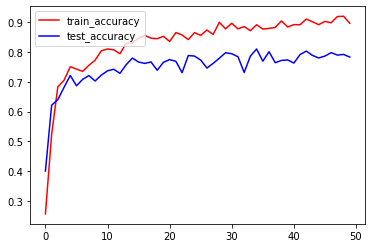

In [41]:
# Visualise train / Valid Accuracy
plt.plot(new_model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(new_model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

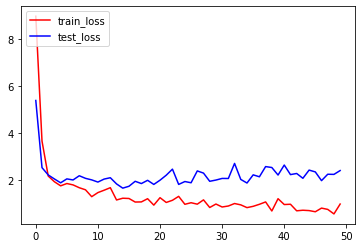

In [42]:
# Visualise train / Valid Loss
plt.plot(new_model.history.history["loss"], c="r", label="train_loss")
plt.plot(new_model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()